In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from dask.distributed import Client

client = Client(processes=True)
client

Client Scheduler: tcp://127.0.0.1:55406 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [4]:
epoch_key = 'bon', 3, 2
exclude_interneuron_spikes = True

In [5]:
from src.load_data import load_data
import logging

logging.basicConfig(level='INFO', format='%(asctime)s %(message)s',
                    datefmt='%d-%b-%y %H:%M:%S')

animal, day, epoch = epoch_key
data_type, dim = 'clusterless', '1D'

logging.info('Loading data...')
data = load_data(epoch_key,
                 exclude_interneuron_spikes=exclude_interneuron_spikes)

21-Dec-20 16:03:48 Loading data...
21-Dec-20 16:03:49 Loading position info...
21-Dec-20 16:09:51 Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
21-Dec-20 16:09:51 No DIO file found, using distance from well to segment trials
21-Dec-20 16:09:51 Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
21-Dec-20 16:09:51 No DIO file found, inferring correct inbound/outbound from task rules
21-Dec-20 16:10:26 Loading spikes...
21-Dec-20 16:11:16 Loading multiunit...
21-Dec-20 16:11:25 Finding ripple times...
21-Dec-20 16:35:34 Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
21-Dec-20 16:35:34 No DIO file found, using distance from well to segment trials
21-Dec-20 16:35:36 Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
21-Dec-20 16:35:36 No DIO file found, 

In [6]:
client.close()

In [7]:
from loren_frank_data_processing.position import (EDGE_ORDER, EDGE_SPACING,
                                                  make_track_graph)
from src.parameters import ANIMALS, PROCESSED_DATA_DIR

is_training = data['position_info'].speed > 4
position = data['position_info'].loc[:, 'linear_position']
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

In [8]:
import os
import xarray as xr
from replay_trajectory_classification import ClusterlessClassifier
from loren_frank_data_processing import reshape_to_segments


model_name = os.path.join(
    PROCESSED_DATA_DIR,
    f'{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl')

results = xr.open_dataset(
    os.path.join(
        PROCESSED_DATA_DIR, f'{animal}_{day:02}_{epoch:02}.nc'),
    group=f'/{data_type}/{dim}/classifier/ripples/')
logging.info('Found existing results. Loading...')
ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]
spikes = (((data['multiunit'].sum('features') > 0) * 1.0)
          .to_dataframe(name='spikes').unstack())
spikes.columns = data['tetrode_info'].tetrode_id
ripple_spikes = reshape_to_segments(spikes, ripple_times)
classifier = ClusterlessClassifier.load_model(model_name)

21-Dec-20 16:36:55 Found existing results. Loading...


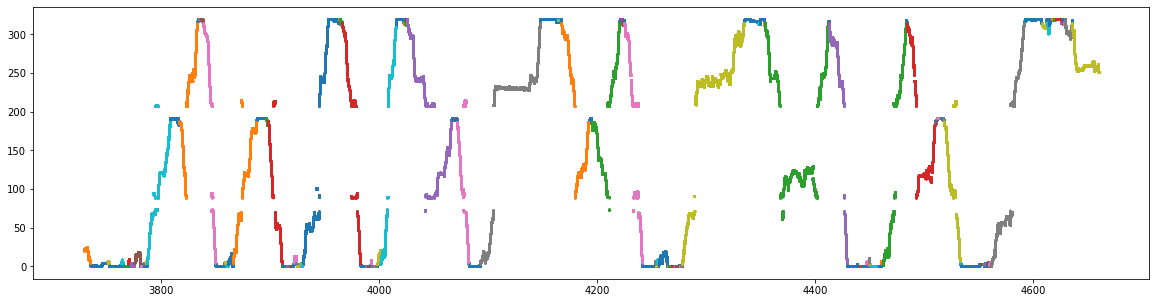

In [31]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(20, 5))
for _, df in data['position_info'].groupby('labeled_segments'):
    plt.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=1)

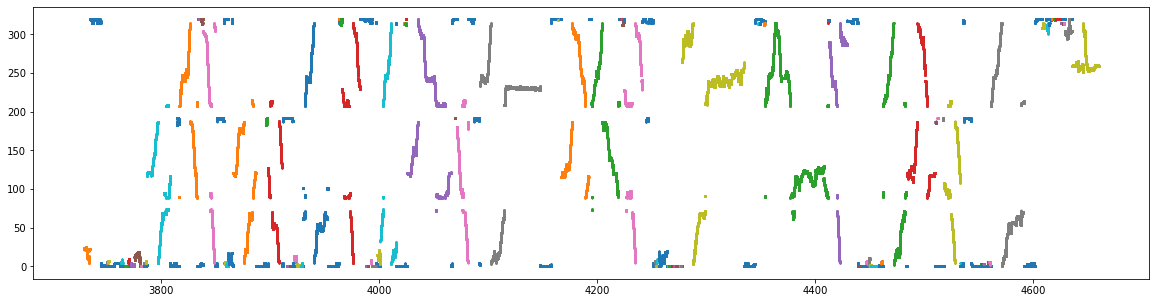

In [30]:
plt.figure(figsize=(20, 5))
for _, df in data['position_info'].groupby('labeled_segments'):
    plt.scatter(df.index / np.timedelta64(1, 's'), np.roll(df.linear_position, 5000), s=1)

In [32]:
ripple_times = data["ripple_times"]
position_info = data["position_info"]
ripple_consensus_trace_zscore = data["ripple_consensus_trace_zscore"]

In [35]:
import pandas as pd

# Interpolate ripple zscore to 500 Hz sampling rate
new_index = pd.Index(np.unique(np.concatenate(
    (ripple_consensus_trace_zscore.index, position_info.index))),
    name='time')
ripple_consensus_trace_zscore = (ripple_consensus_trace_zscore
                                 .reindex(index=new_index)
                                 .interpolate(method='linear')
                                 .reindex(index=position_info.index)
                                 )

In [40]:
ripple = next(ripple_times.itertuples())

In [41]:
ripple

Pandas(Index=1, start_time=Timedelta('0 days 01:02:20.175033'), end_time=Timedelta('0 days 01:02:20.281700'), duration=0.106666667)

In [43]:
from src.parameters import PROBABILITY_THRESHOLD, SAMPLING_FREQUENCY

probability_threshold = PROBABILITY_THRESHOLD
sampling_frequency = SAMPLING_FREQUENCY

In [108]:
def get_replay_linear_position(is_classified, map_estimate):
    labels, n_labels = scipy.ndimage.label(is_classified)
    return np.asarray([np.mean(map_estimate[labels == label])
                       for label in range(1, n_labels + 1)])

In [114]:
from src.analysis import (duration, fraction_of_time, n_tetrodes_active,
                          n_total_spikes, fraction_spikes_less_than_6_ms,
                          population_rate, median_spikes_per_bin,
                          get_probability, get_is_classified,
                          maximum_a_posteriori_estimate, calculate_replay_distance,
                          gaussian_smooth, highest_posterior_density,
                          get_state_order
                         )
import scipy


def get_ripple_replay_info(ripple, results, spikes,
                           ripple_consensus_trace_zscore, position_info,
                           sampling_frequency, probability_threshold,
                           track_graph):

    start_time = ripple.start_time
    end_time = ripple.end_time
    ripple_duration = ripple.duration

    ripple_time_slice = slice(start_time, end_time)

    result = (results
              .sel(ripple_number=ripple.Index)
              .dropna('time', how='all')
              .assign_coords(
                time=lambda ds: ds.time / np.timedelta64(1, 's')))
    probability = get_probability(result)
    is_classified = get_is_classified(probability, probability_threshold).astype(bool)
    is_unclassified = (is_classified.sum('state') < 1).assign_coords(
        state='Unclassified')
    is_classified = xr.concat((is_classified, is_unclassified), dim='state')

    classified = (~is_classified.sel(state='Unclassified')).sum('time').values > 0

    ripple_spikes = spikes.loc[ripple_time_slice]
    ripple_consensus = np.asarray(
        ripple_consensus_trace_zscore.loc[ripple_time_slice])

    posterior = result.acausal_posterior
    map_estimate = maximum_a_posteriori_estimate(posterior.sum('state'))

    ripple_position_info = position_info.loc[ripple_time_slice]

    actual_positions = np.asarray(
        ripple_position_info.loc[ripple_time_slice, ['x_position', 'y_position']])
    actual_track_segment_ids = np.asarray(
        ripple_position_info.loc[ripple_time_slice, 'track_segment_id']
    ).squeeze().astype(int)

    (replay_distance_from_actual_position,
     replay_distance_from_center_well) = calculate_replay_distance(
        track_graph, map_estimate, actual_positions,
        actual_track_segment_ids, position_info)

    try:
        replay_total_displacement = np.abs(
            replay_distance_from_center_well[-1] -
            replay_distance_from_center_well[0])
    except IndexError:
        replay_total_displacement = np.nan

    time = np.asarray(posterior.time)
    map_estimate = map_estimate.squeeze()
    replay_speed = np.abs(np.gradient(
        replay_distance_from_center_well, time))
    SMOOTH_SIGMA = 0.0025
    replay_speed = gaussian_smooth(
        replay_speed, SMOOTH_SIGMA, sampling_frequency)
    replay_velocity_actual_position = np.gradient(
        replay_distance_from_actual_position, time)
    replay_velocity_center_well = np.gradient(
        replay_distance_from_center_well, time)

    hpd_threshold = highest_posterior_density(
        posterior.sum("state"), coverage=0.95)
    isin_hpd = posterior.sum("state") >= hpd_threshold[:, np.newaxis]
    spatial_coverage = (
        isin_hpd * np.diff(posterior.position)[0]).sum("position").values
    n_position_bins = (posterior.sum("state", skipna=True)
                       > 0).sum("position").values[0]
    spatial_coverage_percentage = (isin_hpd.sum("position") /
                                   n_position_bins).values
    distance_change = np.abs(np.diff(replay_distance_from_center_well))
    distance_change = np.insert(distance_change, 0, 0)

    metrics = {
        'start_time': start_time,
        'end_time': end_time,
        'duration': ripple_duration,
        'is_classified': classified,
        'n_unique_spiking': n_tetrodes_active(ripple_spikes),
        'n_total_spikes': n_total_spikes(ripple_spikes),
        'median_fraction_spikes_under_6_ms': np.nanmedian(
                fraction_spikes_less_than_6_ms(
                    ripple_spikes, sampling_frequency)
            ),
        'median_spikes_per_bin': median_spikes_per_bin(
                ripple_spikes),
        'population_rate': population_rate(
                ripple_spikes, sampling_frequency),
        'actual_x_position': np.mean(np.asarray(ripple_position_info.x_position)),
        'actual_y_position': np.mean(np.asarray(ripple_position_info.y_position)),
        'actual_linear_distance': np.mean(np.asarray(ripple_position_info.linear_distance)),
        'actual_linear_position': np.mean(np.asarray(ripple_position_info.linear_position)),
        'actual_speed': np.mean(np.asarray(ripple_position_info.speed)),
        'actual_velocity_center_well': np.mean(np.asarray(ripple_position_info.linear_velocity)),
        'replay_distance_from_actual_position': np.mean(
            replay_distance_from_actual_position),
        'replay_speed': np.mean(replay_speed),
        'replay_velocity_actual_position': np.mean(
            replay_velocity_actual_position),
        'replay_velocity_center_well': np.mean(replay_velocity_center_well),
        'replay_distance_from_center_well': np.mean(
            replay_distance_from_center_well),
        'replay_linear_position': np.mean(map_estimate),
        'replay_total_distance': np.sum(distance_change),
        'replay_total_displacement': replay_total_displacement,
        'state_order': get_state_order(is_classified),
        'spatial_coverage': np.mean(spatial_coverage),
        'spatial_coverage_percentage': np.mean(spatial_coverage_percentage),
        'mean_ripple_consensus_trace_zscore': np.mean(
            ripple_consensus),
        'max_ripple_consensus_trace_zscore': np.max(
            ripple_consensus),
    }

    for state, above_threshold in is_classified.groupby('state'):
        above_threshold = above_threshold.astype(bool).values.squeeze()
        metrics[f'{state}'] = np.sum(above_threshold) > 0
        try:
            metrics[f'{state}_max_probability'] = np.max(
                np.asarray(probability.sel(state=state)))
        except (KeyError, ValueError):
            metrics[f'{state}_max_probability'] = np.nan

        metrics[f'{state}_duration'] = duration(
            above_threshold, sampling_frequency)
        metrics[f'{state}_fraction_of_time'] = fraction_of_time(
            above_threshold, time)

        if np.any(above_threshold):
            metrics[f'{state}_replay_distance_from_actual_position'] = np.mean(
                replay_distance_from_actual_position[above_threshold])  # cm
            metrics[f'{state}_replay_speed'] = np.mean(
                replay_speed[above_threshold])  # cm / s
            metrics[f'{state}_replay_velocity_actual_position'] = np.mean(
                replay_velocity_actual_position[above_threshold])  # cm / s
            metrics[f'{state}_replay_velocity_center_well'] = np.mean(
                replay_velocity_center_well[above_threshold])  # cm / s
            metrics[f'{state}_replay_distance_from_center_well'] = np.mean(
                replay_distance_from_center_well[above_threshold])  # cm
            metrics[f'{state}_replay_linear_position'] = get_replay_linear_position(above_threshold, map_estimate)  # cm
            metrics[f'{state}_replay_total_distance'] = np.sum(
                distance_change[above_threshold])  # cm
            metrics[f'{state}_min_time'] = np.min(time[above_threshold])  # s
            metrics[f'{state}_max_time'] = np.max(time[above_threshold])  # s
            metrics[f'{state}_n_unique_spiking'] = n_tetrodes_active(
                ripple_spikes.iloc[above_threshold])
            metrics[f'{state}_n_total_spikes'] = n_total_spikes(
                ripple_spikes.iloc[above_threshold])
            metrics[f'{state}_median_fraction_spikes_under_6_ms'] = np.nanmedian(
                fraction_spikes_less_than_6_ms(
                    ripple_spikes.iloc[above_threshold], sampling_frequency)
            )
            metrics[f'{state}_population_rate'] = population_rate(
                ripple_spikes.iloc[above_threshold], sampling_frequency)
            metrics[f'{state}_median_spikes_per_bin'] = median_spikes_per_bin(
                ripple_spikes.loc[above_threshold])
            metrics[f'{state}_spatial_coverage'] = np.median(
                spatial_coverage[above_threshold])  # cm
            metrics[f'{state}_spatial_coverage_percentage'] = np.median(
                spatial_coverage_percentage[above_threshold])
            metrics[f"{state}_Hov_avg_prob"] = float(
                probability.sel(state="Hover").isel(
                    time=above_threshold).mean()
            )
            metrics[f"{state}_Cont_avg_prob"] = float(
                probability.sel(state="Continuous").isel(
                    time=above_threshold).mean()
            )
            metrics[f"{state}_Frag_avg_prob"] = float(
                probability.sel(state="Fragmented").isel(
                    time=above_threshold).mean()
            )
            metrics[f"{state}_mean_ripple_consensus_trace_zscore"] = np.mean(
                ripple_consensus[above_threshold])
            metrics[f"{state}_max_ripple_consensus_trace_zscore"] = np.max(
                ripple_consensus[above_threshold])
            
    return metrics

In [118]:
replay_info = pd.DataFrame(
    [get_ripple_replay_info(ripple, results, spikes,
                            ripple_consensus_trace_zscore,
                            position_info)
     for ripple in ripple_times.itertuples()], index=ripple_times.index)

In [119]:
animal, day, epoch = epoch_key

replay_info['animal'] = animal
replay_info['day'] = int(day)
replay_info['epoch'] = int(epoch)

min_max = (
    classifier
    ._nodes_df[classifier._nodes_df.is_bin_edge]
    .groupby('edge_id')
    .aggregate(['min', 'max']))

replay_info['center_well_position'] = min_max.loc[0].linear_position.min()
replay_info['choice_position'] = min_max.loc[0].linear_position.max()

replay_info['left_arm_start'] = min_max.loc[1].linear_position.min()
replay_info['left_well_position'] = min_max.loc[3].linear_position.max()

replay_info['right_arm_start'] = min_max.loc[2].linear_position.min()
replay_info['right_well_position'] = min_max.loc[4].linear_position.max()
center_well_id = 0
replay_info['max_linear_distance'] = list(
    classifier.distance_between_nodes_[center_well_id].values())[-1]

In [133]:
replay_info.loc[replay_info.Hover_replay_distance_from_actual_position > 30].Hover_replay_linear_position.values / min_max.loc[3].linear_position.max()

array([array([0.99545338]), array([0.09735056]), array([0.99545338]),
       array([0.99545338]), array([0.99545338]), array([0.99545338]),
       array([0.99545338]), array([0.99545338]), array([0.99545338]),
       array([0.09735056])], dtype=object)

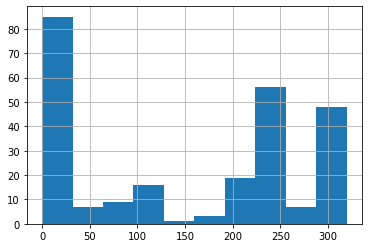

In [129]:
replay_info.actual_linear_position.hist()

In [140]:
np.concatenate(replay_info.loc[replay_info.Hover_replay_distance_from_actual_position > 30].Hover_replay_linear_position.values)

array([317.96388117,  31.0953392 , 317.96388117, 317.96388117,
       317.96388117, 317.96388117, 317.96388117, 317.96388117,
       317.96388117,  31.0953392 ])

In [160]:
from src.analysis import get_replay_info

replay_info = get_replay_info(
    results, spikes, data['ripple_times'], data['position_info'],
    track_graph, sampling_frequency, probability_threshold,
    epoch_key, classifier, data['ripple_consensus_trace_zscore'])

replay_info

,start_time,end_time,duration,is_classified,n_unique_spiking,n_total_spikes,median_fraction_spikes_under_6_ms,median_spikes_per_bin,population_rate,actual_x_position,...,animal,day,epoch,center_well_position,choice_position,left_arm_start,left_well_position,right_arm_start,right_well_position,max_linear_distance
ripple_number,,,,,,,,,,,,,,,,,,,,,
1,01:02:20.175033,01:02:20.281700,0.106667,True,19,136,0.279221,2.0,54.750403,211.950000,...,bon,3,2,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915
2,01:02:22.785700,01:02:22.904366,0.118667,True,19,226,0.437500,3.5,81.884058,212.228333,...,bon,3,2,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915
3,01:02:27.075700,01:02:27.181700,0.106000,True,19,238,0.578947,4.0,95.813205,213.300000,...,bon,3,2,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915
4,01:02:29.244366,01:02:29.301033,0.056667,True,17,108,0.444444,4.0,83.850932,213.300000,...,bon,3,2,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915
5,01:02:34.055033,01:02:34.112366,0.057333,True,15,73,0.414286,2.0,54.722639,215.195842,...,bon,3,2,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,01:17:29.603033,01:17:29.685700,0.082667,True,17,149,0.500000,3.0,77.122153,166.500000,...,bon,3,2,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915
248,01:17:31.262366,01:17:31.344366,0.082000,True,16,86,0.266667,2.0,45.599152,167.393544,...,bon,3,2,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915
249,01:17:32.299033,01:17:32.435033,0.136000,True,21,353,0.555556,5.0,112.851662,167.400000,...,bon,3,2,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915


In [162]:
data['tetrode_info']

area  depth hemisphere  maxcell  nearCA2  \
animal day epoch tetrode_number                                            
bon    3   2     1               CA3  149.0      right      NaN      0.0   
                 2               CA3  151.0      right      NaN      0.0   
                 3               CA1  100.0      right      NaN      0.0   
                 4               CA1  107.0      right      NaN      0.0   
                 5               CA1  105.0      right      NaN      0.0   
                 7               CA3  162.0      right      NaN      0.0   
                 8               CA3  153.0      right      NaN      0.0   
                 10              CA3  146.0      right      NaN      0.0   
                 11              CA1   95.0      right      NaN      0.0   
                 12              CA1  136.0       left      NaN      0.0   
                 13              CA1   93.0       left      NaN      0.0   
                 14              CA1   96.0       left      NaN      0.0   
                 17              CA1  108.0       left      NaN      0.0   
                 18              CA3  138.0       left      NaN      0.0   
                 19              CA3  130.0       left      NaN      0.0   
                 20              CA3  132.0       left      1.0      0.0   
                 21              CA3  146.0       left      NaN      0.0   
                 22              CA3  171.0       left      NaN      0.0   
                 23              CA3  152.0       left      NaN      0.0   
                 24              CA1  109.0       left      NaN      0.0   
                 25              CA3  144.0       left      NaN      0.0   
                 28              CA1  100.0      right      NaN      0.0   
                 29              CA1  118.0      right      1.0      0.0   

                                 numcells  representative subarea  \
animal day epoch tetrode_number                                     
bon    3   2     1                    6.0             1.0    CA3b   
                 2                    0.0             NaN    CA3b   
                 3                    3.0             NaN    CA1c   
                 4                    0.0             NaN    CA1c   
                 5                    5.0             NaN    CA1c   
                 7                    0.0             NaN    CA3b   
                 8                    0.0             NaN    CA3b   
                 10                   0.0             NaN    CA3b   
                 11                   0.0             NaN    CA1c   
                 12                   2.0             NaN    CA1c   
                 13                   1.0             NaN    CA1c   
                 14                   2.0             1.0    CA1c   
                 17                   1.0             NaN    CA1c   
                 18                   3.0             NaN    CA3b   
                 19                   2.0             NaN    CA3b   
                 20                   6.0             NaN    CA3b   
                 21                   0.0             NaN    CA3b   
                 22                   1.0             NaN    CA3b   
                 23                   3.0             NaN    CA3b   
                 24                   2.0             NaN    CA1c   
                 25                   0.0             NaN    CA3b   
                 28                   0.0             NaN    CA1c   
                 29                   5.0             NaN    CA1c   

                                    tetrode_id  validripple  
animal day epoch tetrode_number                              
bon    3   2     1               bon_03_02_001          0.0  
                 2               bon_03_02_002          0.0  
                 3               bon_03_02_003          1.0  
                 4               bon_03_02_004          0.0  
                 5               

In [164]:
from loren_frank_data_processing import get_multiunit_dataframe

get_multiunit_dataframe(('bon', 3, 2, 1), ANIMALS)

,channel_1_max,channel_2_max,channel_3_max,channel_4_max,max_width,max_height_change,x_position,y_position
time,,,,,,,,
00:41:06.404200,82.384961,62.745503,50.968333,53.464103,5.900259,116.0,-0.266460,-0.088654
00:41:06.411200,89.221070,85.923881,65.767131,71.856073,7.462277,166.0,-1.026000,0.788207
00:41:06.431200,76.296760,77.996778,81.399956,81.691544,7.213685,135.0,0.077205,-0.922039
00:41:06.449600,57.435006,72.598918,35.216071,32.246836,5.971965,155.0,0.177209,0.898393
00:41:06.461000,82.910080,74.511414,61.177506,60.668433,6.782598,179.0,-0.706226,-1.652593
...,...,...,...,...,...,...,...,...
02:47:37.174400,55.083456,50.475467,52.970203,74.559954,5.651699,144.0,234.505792,102.252370
02:47:37.177600,28.923577,35.580122,72.662331,27.806655,4.388787,171.0,235.367853,100.612962
02:47:37.179300,46.108473,33.458280,44.263771,70.667638,6.105698,146.0,235.603943,98.731184
